## **Python. Работа с грязными данными**

### **Описание**

Данные имеют следующую структуру:

* записываются для каждого пользователя, совершившего покупки, каждый день
* для каждой даты есть своя папка, внутри неё – папки для каждого пользователя
* внутри каждой папки есть файл data.csv, где и хранятся данные

Схематично выглядит так:

```
└── data
   ├── 2020-12-30
   │  ├── FirstName_LastName1
   │  │   └── data.csv
   │  ├── FirstName_LastName2
   │  │   └── data.csv
   │  └── FirstName_LastName3
   │      └── data.csv
   └── 2020-12-31
      ├── FirstName_LastName1
      │   └── data.csv
      └── FirstName_LastName5
          └── data.csv
```
          
Например, 30 декабря три покупателя сделали покупки, 31 – два (папки 2020-12-30 и 2020-12-31 соответственно). 

Поскольку клиент FirstName_LastName1 купил товары в оба дня, для него имеется папка в папке для каждой из дат. Для других клиентов – по одной.

### **Задачи**

* Соберите все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id, quantity), а также имя пользователя (name), и дата этих покупок (date, соответствует названию папки, где лежит папка с пользователем)
* Выясните, какой пользователь купил больше всего товаров. Если их несколько, то перечислите имена через запятую с пробелом и в алфавитном порядке.
* Найдите топ-10 товаров по числу проданных единиц за всё время и постройте барплот. Сколько было продано единиц товара с product_id==56?
* Визуализируйте продажи по дням.
* Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни.

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import os
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## **Задание 1. Сбор файлов в датафрэйм**

Можем решить эту задачу исклбючительно средствами библиотеки **OS**, или более современный способ с помощью библиотеки **pathlib**

Для начала попробуем первый вариант

In [2]:
# сохраним в переменную путь к папке с данными
path = r'C:\Users\Oleg Savkin\Projects\Python\mp_01\MP_Data'

In [3]:
# с помощью метода os.listdir(), можем вывести список файлов или папок лежащих по нашему пути
os.listdir(path) 

['2020-12-03',
 '2020-12-04',
 '2020-12-05',
 '2020-12-06',
 '2020-12-07',
 '2020-12-08',
 '2020-12-09']

С помощью цикла и метода **os.walk()** можем пройтись по всем папкам в указанном пути

In [4]:
# Посмотрим на небольшом примере, остановив цикл когда он пройдет первую папку и все ее содержимое
for i in os.walk(path):
    print(i)
    break

('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data', ['2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09'], [])


In [5]:
# с помощью конкатенации можем пройтись по конкретной папке, например '2020-12-05'
for i in os.walk(path + r'\2020-12-05'):
    print(i)

('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05', ['Alexey_Fedorov', 'Alexey_Petrov', 'Kirill_Smirnov', 'Petr_Ivanov', 'Petr_Smirnov', 'Rostislav_Smirnov'], [])
('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Alexey_Fedorov', [], ['data.csv'])
('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Alexey_Petrov', [], ['data.csv'])
('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Kirill_Smirnov', [], ['data.csv'])
('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Petr_Ivanov', [], ['data.csv'])
('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Petr_Smirnov', [], ['data.csv'])
('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Rostislav_Smirnov', [], ['data.csv'])


Мы видим, что на выходе мы получаем кортежи, содержащие:
* строку (путь к файлу)
* список папок лежащих по этому пути
* пустой список, означающий. что больше папок в данной директории нет
* и в конце список с нашим файлом, лежащим в папке

In [6]:
# создадим пустой список куда буду добавлятся полученные с помощью цикла значения
folder = []
for triple in os.walk(path):
    folder.append(triple)
folder[1]

('C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-03',
 ['Alexey_Smirnov',
  'Anton_Petrov',
  'Kirill_Petrov',
  'Petr_Fedorov',
  'Vasiliy_Ivanov',
  'Vasiliy_Petrov'],
 [])

Cоздадим новый датафрейм использовав полученный список

In [7]:
# Считаем данные из каждого файла
# С помощью цикла заполним пустой датафрейм нужными нам значениями
df = pd.DataFrame()

for address, dirs, files in folder:
    for file in files:
        path_to_file = (f'{address}\\{file}') # задаем полный путь для каждого файла
        temp_df = pd.read_csv(path_to_file) # каждый новый csv-файл будет перезаписываться в temp_df
        df = pd.concat([df, temp_df]) # с помощью метода pd.concat(), вклеиваем temp_df в итоговый df и повторояем цикл

df

,Unnamed: 0,product_id,quantity
0,0,47,1
1,1,57,1
2,2,14,2
3,3,52,1
4,4,1,4
...,...,...,...
1,1,66,4
2,2,39,2
0,0,82,4
1,1,74,2


Теперь нам необходимо создать колонки name (у каждого пользователся своя папка, соответсвующая его имени) и date (соответствует названию папки, где лежит папка с пользователем)

In [8]:
# разберем алгоритм на учебном примере
# сохраним в переменную путь до любого плозьзователя
path_part = 'C:\\Users\\Oleg Savkin\\Projects\\Python\\mp_01\\MP_Data\\2020-12-05\\Rostislav_Smirnov' \
            .split('\\') # применим метод split() по '\\'

path_part

['C:',
 'Users',
 'Oleg Savkin',
 'Projects',
 'Python',
 'mp_01',
 'MP_Data',
 '2020-12-05',
 'Rostislav_Smirnov']

In [9]:
# теперь мы можем проиндексироваться по списку и присвоить нужные значения переменным
name = path_part[-1]
date = path_part[-2]

name, date

('Rostislav_Smirnov', '2020-12-05')

In [10]:
# добавим к нашему циклу новые данные
df = pd.DataFrame()

for address, dirs, files in folder:
    for file in files:
        # получаем полный путь к файлу и записываем его в переменную
        data_file = (address + '\\' + file)
        
        # считываем данные из каждого файла
        temp_df = pd.read_csv(data_file)
        
        # извлекаем date и name
        path_part = address.split('\\')
        name = path_part[-1]
        date = path_part[-2]
        
        # добавляем колонки
        temp_df['name'] = name
        temp_df['date'] = date
        
        # объединям наши датафреймы
        df = pd.concat([df, temp_df])

df

,Unnamed: 0,product_id,quantity,name,date
0,0,47,1,Alexey_Smirnov,2020-12-03
1,1,57,1,Alexey_Smirnov,2020-12-03
2,2,14,2,Alexey_Smirnov,2020-12-03
3,3,52,1,Alexey_Smirnov,2020-12-03
4,4,1,4,Alexey_Smirnov,2020-12-03
...,...,...,...,...,...
1,1,66,4,Rostislav_Petrov,2020-12-09
2,2,39,2,Rostislav_Petrov,2020-12-09
0,0,82,4,Vasiliy_Ivanov,2020-12-09
1,1,74,2,Vasiliy_Ivanov,2020-12-09


In [11]:
# удалим ненужную нам колонку и перезапишем
df.drop(columns=['Unnamed: 0'], inplace=True)

# сбросим индекс
df.reset_index(drop=True, inplace=True) 

# получаем наш итоговый датафрейм
df

,product_id,quantity,name,date
0,47,1,Alexey_Smirnov,2020-12-03
1,57,1,Alexey_Smirnov,2020-12-03
2,14,2,Alexey_Smirnov,2020-12-03
3,52,1,Alexey_Smirnov,2020-12-03
4,1,4,Alexey_Smirnov,2020-12-03
...,...,...,...,...
156,66,4,Rostislav_Petrov,2020-12-09
157,39,2,Rostislav_Petrov,2020-12-09
158,82,4,Vasiliy_Ivanov,2020-12-09
159,74,2,Vasiliy_Ivanov,2020-12-09


==========================================================================================

Теперь попробуем альтернативный способ с помощью pathlib. Нам пригодится модуль Path из это библиотеки

In [12]:
# теперь наш путь не строка. а отдельный тип данных
alt_path = Path(r'C:\Users\Oleg Savkin\Projects\Python\mp_01\MP_Data')
alt_path

WindowsPath('C:/Users/Oleg Savkin/Projects/Python/mp_01/MP_Data')

In [13]:
# С помощью метода glob и паттерна ```('**/*.csv')``` можем пройтись по по всем папкам
alt_path.glob('**/*.csv')

<generator object Path.glob at 0x0000022F3A306CF0>

In [14]:
# создаем пустой df, куда будут писаться наши данные
df = pd.DataFrame()

# проходимся по папкам с помощью цикла и считываем файлы
for csv_path in alt_path.glob('**/*.csv'):
    temp_df = pd.read_csv(csv_path)
    
    # объединям наши датафреймы
    df = pd.concat([df, temp_df])

df

,Unnamed: 0,product_id,quantity
0,0,47,1
1,1,57,1
2,2,14,2
3,3,52,1
4,4,1,4
...,...,...,...
1,1,66,4
2,2,39,2
0,0,82,4
1,1,74,2


In [15]:
# для извлечения имени и даты ипользуем атрибут parts() из библиотеки pathlib
# как видиим, индексация сдвинется на один пункт, так как индекс [-1] будет именем файла
csv_path.parts

('C:\\',
 'Users',
 'Oleg Savkin',
 'Projects',
 'Python',
 'mp_01',
 'MP_Data',
 '2020-12-09',
 'Vasiliy_Ivanov',
 'data.csv')

In [16]:
# соберем наш итоговый датафрейм
df = pd.DataFrame()

for csv_path in alt_path.glob('**/*.csv'):
    temp_df = pd.read_csv(csv_path)
    
    # извлекаем имя и дату
    name = csv_path.parts[-2]
    date = csv_path.parts[-3]

    # добавляем колонки
    temp_df['name'] = name
    temp_df['date'] = date

    # объеденим наши датафреймы
    df = pd.concat([df, temp_df])

# так же удалим ненужную нам колонку и сбросим индекс
df.drop(columns=['Unnamed: 0'], inplace=True)
df.reset_index(drop=True, inplace=True) 

df

,product_id,quantity,name,date
0,47,1,Alexey_Smirnov,2020-12-03
1,57,1,Alexey_Smirnov,2020-12-03
2,14,2,Alexey_Smirnov,2020-12-03
3,52,1,Alexey_Smirnov,2020-12-03
4,1,4,Alexey_Smirnov,2020-12-03
...,...,...,...,...
156,66,4,Rostislav_Petrov,2020-12-09
157,39,2,Rostislav_Petrov,2020-12-09
158,82,4,Vasiliy_Ivanov,2020-12-09
159,74,2,Vasiliy_Ivanov,2020-12-09


### **Задача 2. Топ клиент по числу покупок**
Выясните, какой пользователь купил больше всего товаров. Если их несколько, то перечислите имена через запятую с пробелом и в алфавитном порядке.

In [17]:
# группируемся по пользователям
# агрегируем по колонке quantity и посчитаем сумму покупок для каждого пользователя
# и отсортируем по убыванию

df.groupby('name') \
    .agg({'quantity' : 'sum'}) \
    .sort_values('quantity', ascending=False)

,quantity
name,
Alexey_Smirnov,52
Petr_Smirnov,52
Anton_Smirnov,45
Petr_Fedorov,34
Kirill_Fedorov,28
Rostislav_Petrov,28
Vasiliy_Ivanov,27
Alexey_Fedorov,24
Anton_Ivanov,23


Ответ: Alexey_Smirnov, Petr_Smirnov

### **Задача 3. Топ 10 проданных товаров**
Найдите топ-10 товаров по числу проданных единиц за всё время и постройте барплот где:

* по оси x – идентификаторы товаров (product_id) 
* по оси y – суммарное число их покупок (сколько товаров с таким product_id было продано)

Для практики попробуйте изменить параметры графика: цвет (color), прозрачность (alpha), сортировку значений по оси х (order). 

В качестве ответа укажите, сколько было продано единиц товара с product_id равным 56.

In [18]:
df.head()

,product_id,quantity,name,date
0,47,1,Alexey_Smirnov,2020-12-03
1,57,1,Alexey_Smirnov,2020-12-03
2,14,2,Alexey_Smirnov,2020-12-03
3,52,1,Alexey_Smirnov,2020-12-03
4,1,4,Alexey_Smirnov,2020-12-03


In [19]:
# группируем по product_id
# и считаем сумму по колонке quantity
# сортируем значения по убыванию
# с помощью head(10) выведем топ-10 значений

top_10 = df.groupby('product_id', as_index=False) \
           .agg({'quantity' : 'sum'}) \
           .sort_values('quantity', ascending=False) \
           .head(10)

top_10

,product_id,quantity
22,27,20
42,56,18
21,24,15
51,74,15
32,41,14
27,34,13
66,94,13
46,66,13
65,92,12
38,50,12


<AxesSubplot:xlabel='product_id', ylabel='quantity'>

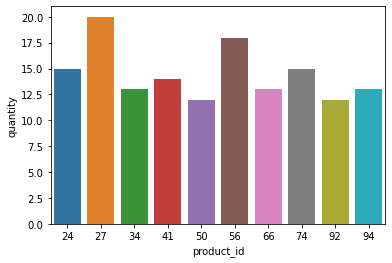

In [20]:
# построим барплот
sns.barplot(x='product_id', y='quantity', data=top_10)

<AxesSubplot:xlabel='product_id', ylabel='quantity'>

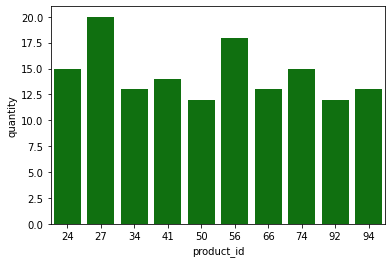

In [21]:
# параметр color='x' - отвечает за цвет графика
sns.barplot(x='product_id', y='quantity', data=top_10, color="green")

<AxesSubplot:xlabel='product_id', ylabel='quantity'>

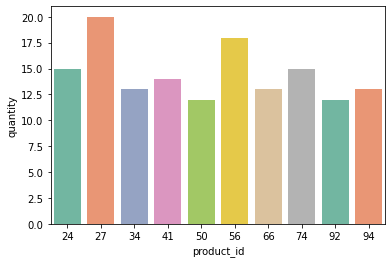

In [22]:
# параметр palette="x" - разные палитры цветов
# цвета можно посмотреть на сайте seaborn
sns.barplot(x='product_id', y='quantity', data=top_10, palette="Set2")

<AxesSubplot:xlabel='product_id', ylabel='quantity'>

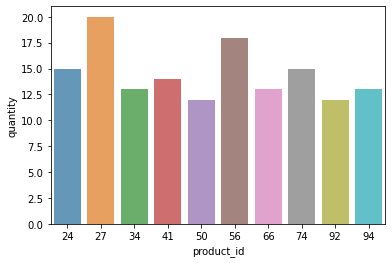

In [23]:
# параметр alpha="x" - отвечает за прозрачность. Указывается дробным значением (проценты)
sns.barplot(x='product_id', y='quantity', data=top_10,  alpha=0.75)

От нас требуется указать сколько было продано единиц товара с product_id равным 56

На графике это не очень хорошо видно, отфильтруем нужное нам значение

In [24]:
top_10.query('product_id == 56')

,product_id,quantity
42,56,18


Ответ - 18

==========================================================================================

### **Задача 4. Продажи по дням**
Посмотрим на продажи по дням! 

Для визуализации снова используйте барплот, только теперь по оси x будут дни, по которым у нас есть данные (date). Далее выберите верные утверждения:

* 5 декабря было куплено почти в два раза больше товаров, чем в предыдущий день
* 8 и 9 декабря было продано примерно одинаковое число товаров
* 4 декабря было куплено почти в два раза больше товаров, чем в предыдущий день
* Максимальное число товаров было продано 4 декабря
* Меньше всего товаров было приобретено 6 декабря
* Меньше всего продуктов было приобретено 4 декабря
* 7 декабря было куплено почти в два раза больше товаров, чем в предыдущий день
* 5 декабря было куплено почти в три раза меньше товаров, чем в предыдущий день

In [25]:
# сгруппируемся по дате
# посчитаем сумму по кол-ву продаж
# отсортируемся по дате

days = df.groupby('date', as_index=False) \
         .agg({'quantity' : 'sum'}) \
         .sort_values('date')

days

,date,quantity
0,2020-12-03,60
1,2020-12-04,113
2,2020-12-05,61
3,2020-12-06,15
4,2020-12-07,94
5,2020-12-08,68
6,2020-12-09,69


<AxesSubplot:xlabel='date', ylabel='quantity'>

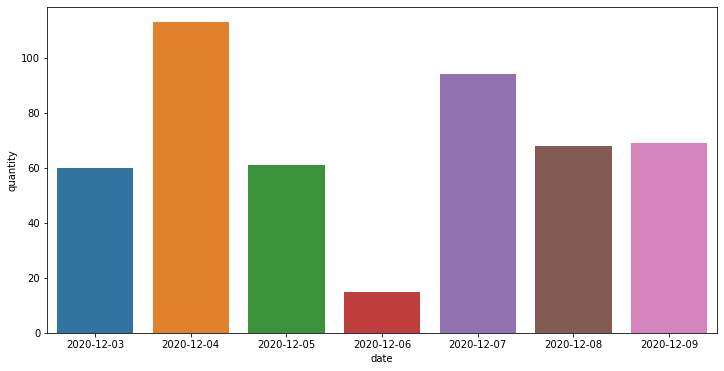

In [26]:
#  построим барплот и увеличим график чтобы было лучше видно

plt.figure(figsize=(12, 6))
sns.barplot(x='date', y='quantity', data=days)

Ответ:

* 5 декабря было куплено почти в два раза больше товаров, чем в предыдущий день
* 8 и 9 декабря было продано примерно одинаковое число товаров - верно
* 4 декабря было куплено почти в два раза больше товаров, чем в предыдущий день - верно
* Максимальное число товаров было продано 4 декабря - верно
* Меньше всего товаров было приобретено 6 декабря - верно
* Меньше всего продуктов было приобретено 4 декабря
* 7 декабря было куплено почти в два раза больше товаров, чем в предыдущий день
* 5 декабря было куплено почти в три раза меньше товаров, чем в предыдущий день

==========================================================================================

### **Задача 5. Поиск повторных покупок**

Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни.

In [27]:
# сгруппируемся по имени и product_id
# посчитаем кол-во уникальных дат для этих групп и по факту получим кол-во уникальных покупок в разные дни
# переименуем колонку для наглядности
# отфильтруем пользователей с кол-вом покупок больше 1 и получим наш ответ

df.groupby(['name', 'product_id'], as_index=False) \
  .agg({'date' : 'nunique'}) \
  .rename(columns={'date' : 'purchases_count'}) \
  .query('purchases_count > 1')

,name,product_id,purchases_count
37,Anton_Ivanov,15,2
92,Petr_Fedorov,94,2


Ответ - 2